In [ ]:
import zipfile as zf
files = zf.ZipFile("101_ObjectCategories_test.zip", 'r')
files.extractall('101_ObjectCategories_test')

## 5-layer CNN

In [17]:
# Image processing from local files

from keras.preprocessing.image import ImageDataGenerator
image_size = 150


# Define directory roots
train_root = './101_ObjectCategories_test/101_ObjectCategories/train'
val_root = './101_ObjectCategories_test/101_ObjectCategories/val'
test_root = './101_ObjectCategories_test/101_ObjectCategories/test'

# Generate training set
train_datagen = ImageDataGenerator(rescale=1./255.)

train_dataset = train_datagen.flow_from_directory(
    train_root,
    target_size=(image_size, image_size),
    batch_size=32
)
                                

# Generate validation set   
val_datagen = ImageDataGenerator(rescale=1./255.)

val_dataset = val_datagen.flow_from_directory(
    val_root,
    target_size=(image_size, image_size),
    batch_size=32
)

# Generate test set
test_datagen = ImageDataGenerator(rescale=1./255.)

test_dataset = test_datagen.flow_from_directory(
    test_root,
    target_size=(image_size, image_size),
    batch_size=32,
    shuffle=False
)

total_length = len(train_dataset.filenames) + len(val_dataset.filenames) + len(test_dataset.filenames)
print("Train, in percentage (%) : ", len(train_dataset.filenames)/total_length * 100)
print("Val, in percentage (%) : ", len(val_dataset.filenames)/total_length * 100)
print("Test, in percentage (%) : ", len(test_dataset.filenames)/total_length * 100)

Found 6782 images belonging to 102 classes.
Found 1464 images belonging to 102 classes.
Found 898 images belonging to 102 classes.
Train, in percentage (%) :  74.16885389326335
Val, in percentage (%) :  16.010498687664043
Test, in percentage (%) :  9.820647419072616


In [6]:

from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout

cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(102, activation='softmax')
])

cnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 15, 15, 256)      

In [7]:
# Compile and fit model
cnn_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy', 'top_k_categorical_accuracy'])

history = cnn_model.fit(train_dataset,
             validation_data=val_dataset,
             epochs=50)

Epoch 1/50
212/212 [==============================] - 82s 389ms/step - loss: 4.0472 - acc: 0.1753 - top_k_categorical_accuracy: 0.3232 - val_loss: 3.6583 - val_acc: 0.2336 - val_top_k_categorical_accuracy: 0.3921
Epoch 2/50
212/212 [==============================] - 75s 356ms/step - loss: 3.3862 - acc: 0.3054 - top_k_categorical_accuracy: 0.4437 - val_loss: 3.1678 - val_acc: 0.3552 - val_top_k_categorical_accuracy: 0.4993
Epoch 3/50
212/212 [==============================] - 74s 348ms/step - loss: 2.9656 - acc: 0.3795 - top_k_categorical_accuracy: 0.5348 - val_loss: 2.8543 - val_acc: 0.4010 - val_top_k_categorical_accuracy: 0.5642
Epoch 4/50
212/212 [==============================] - 75s 352ms/step - loss: 2.5807 - acc: 0.4474 - top_k_categorical_accuracy: 0.6112 - val_loss: 2.6117 - val_acc: 0.4426 - val_top_k_categorical_accuracy: 0.6148
Epoch 5/50
212/212 [==============================] - 77s 362ms/step - loss: 2.2616 - acc: 0.4956 - top_k_categorical_accuracy: 0.6737 - val_loss: 2

In [9]:
# Store model

cnn_model.save("clean_data.h5")

In [10]:
# Save history of model

import numpy as np
data_history_training = history.history

np.save('history_clean_data.npy', data_history_training)

In [3]:
# Evaluate model

from tensorflow import keras

reconstructed_model = keras.models.load_model("clean_data.h5")
reconstructed_model.evaluate(test_dataset)

29/29 [==============================] - 4s 131ms/step - loss: 4.9029 - acc: 0.5802 - top_k_categorical_accuracy: 0.7361


[4.9028880747420525, 0.5801782, 0.73608017]

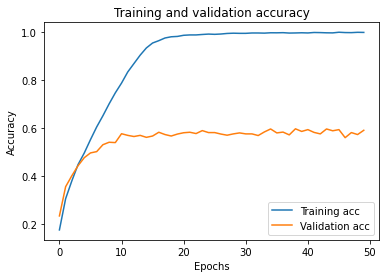

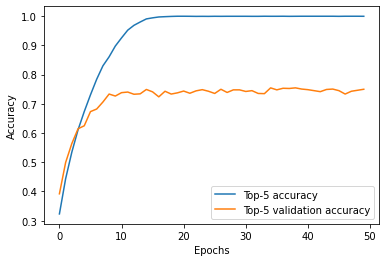

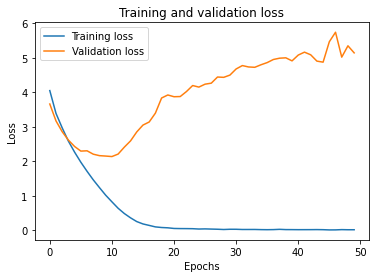

In [4]:
import numpy as np
reconstructed_history = np.load('history_clean_data.npy',allow_pickle='TRUE').item()

import matplotlib.pyplot as plt

acc = reconstructed_history['acc']
val_acc = reconstructed_history['val_acc']
loss = reconstructed_history['loss']
val_loss = reconstructed_history['val_loss']
top_5_acc = reconstructed_history['top_k_categorical_accuracy']
top_5_val_acc = reconstructed_history['val_top_k_categorical_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.figure()

plt.plot(epochs, top_5_acc, label='Top-5 accuracy')
plt.plot(epochs, top_5_val_acc, label='Top-5 validation accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()


In [18]:
from tensorflow import keras

reconstructed_model = keras.models.load_model("clean_data.h5")
predicted = reconstructed_model.predict(test_dataset)

In [19]:
import sklearn

true = test_dataset.classes
predicted = [np.argmax(x) for x in predicted]
predicted = np.array(predicted)

print('\n', sklearn.metrics.classification_report(true, predicted, target_names=labels), sep='') 


                   precision    recall  f1-score   support

BACKGROUND_Google       0.20      0.12      0.15        42
            Faces       0.86      0.93      0.89        45
       Faces_easy       0.95      1.00      0.97        35
         Leopards       0.72      0.72      0.72        25
       Motorbikes       0.97      0.97      0.97        80
        accordion       0.71      0.83      0.77         6
        airplanes       0.96      0.98      0.97        87
           anchor       0.00      0.00      0.00         5
              ant       0.00      0.00      0.00         2
           barrel       0.00      0.00      0.00         4
             bass       0.33      0.12      0.18         8
           beaver       0.50      0.20      0.29         5
        binocular       0.25      0.33      0.29         3
           bonsai       0.64      0.44      0.52        16
            brain       0.50      0.56      0.53         9
     brontosaurus       0.17      0.33      0.22      

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 5-layer CNN with augmented inputs

In [20]:
# Image processing from local files

from keras.preprocessing.image import ImageDataGenerator
image_size = 150


# Define directory roots
train_root = './101_ObjectCategories_test/101_ObjectCategories/train'
val_root = './101_ObjectCategories_test/101_ObjectCategories/val'
test_root = './101_ObjectCategories_test/101_ObjectCategories/test'

# Generate training set
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   zoom_range=0.1,
                                   shear_range=0.2,
                                  )

train_dataset = train_datagen.flow_from_directory(
    train_root,
    target_size=(image_size, image_size),
    batch_size=32
)

print(type(train_dataset))

# Generate validation set   
val_datagen = ImageDataGenerator(rescale=1./255.)

val_dataset = val_datagen.flow_from_directory(
    val_root,
    target_size=(image_size, image_size),
    batch_size=32
)

# Generate test set
test_datagen = ImageDataGenerator(rescale=1./255.)

test_dataset = test_datagen.flow_from_directory(
    test_root,
    target_size=(image_size, image_size),
    batch_size=32,
    shuffle=False
)

total_length = len(train_dataset.filenames) + len(val_dataset.filenames) + len(test_dataset.filenames)
print("Train, in percentage (%) : ", len(train_dataset.filenames)/total_length * 100)
print("Val, in percentage (%) : ", len(val_dataset.filenames)/total_length * 100)
print("Test, in percentage (%) : ", len(test_dataset.filenames)/total_length * 100)

Found 6782 images belonging to 102 classes.
<class 'keras.preprocessing.image.DirectoryIterator'>
Found 1464 images belonging to 102 classes.
Found 898 images belonging to 102 classes.
Train, in percentage (%) :  74.16885389326335
Val, in percentage (%) :  16.010498687664043
Test, in percentage (%) :  9.820647419072616


In [4]:
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(102, activation='softmax')
])

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 256)      

In [75]:
# Compile and fit model
import keras

from tensorflow.keras.metrics import Precision, Recall

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy', 
                       'top_k_categorical_accuracy',
                        #Precision,
                        #Recall,
                        #f1
                      ])

history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=1,
                    callbacks = [MetricsCheckpoint('logs')]
                    )

212/212 [==============================] - 114s 540ms/step - loss: 0.9937 - acc: 0.7277 - top_k_categorical_accuracy: 0.9126 - val_loss: 2.2657 - val_acc: 0.5519 - val_top_k_categorical_accuracy: 0.7753


In [4]:
# Store model

model.save("data_aug_no_shuffle.h5")

In [73]:
# Evaluate model

from tensorflow import keras

reconstructed_model = keras.models.load_model("data_aug_no_shuffle.h5")
reconstructed_model.evaluate(test_dataset)

29/29 [==============================] - 3s 107ms/step - loss: 2.5685 - acc: 0.5969


[2.568480372428894, 0.596882]

In [12]:
# Save history of model

import numpy as np
data_history_training = history.history

np.save('history_augmenter.npy', data_history_training)
    

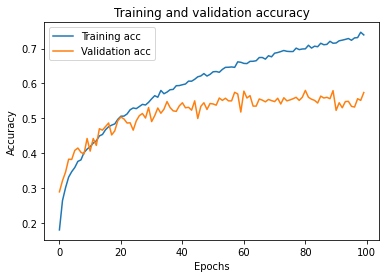

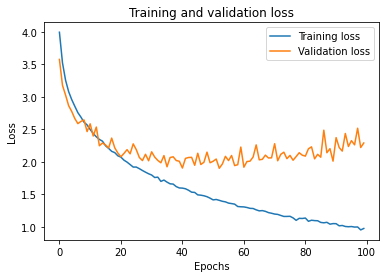

In [3]:
# Plot from stored history

import numpy as np
reconstructed_history = np.load('history_augmenter.npy',allow_pickle='TRUE').item()

import matplotlib.pyplot as plt

acc = reconstructed_history['acc']
val_acc = reconstructed_history['val_acc']
loss = reconstructed_history['loss']
val_loss = reconstructed_history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.figure()
plt.savefig("test.eps", format='eps')

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()



In [21]:
from tensorflow import keras

reconstructed_model = keras.models.load_model("data_aug_no_shuffle.h5")
predicted = reconstructed_model.predict(test_dataset)

In [22]:
import sklearn

true = test_dataset.classes
predicted = [np.argmax(x) for x in predicted]
predicted = np.array(predicted)

print('\n', sklearn.metrics.classification_report(true, predicted, target_names=labels), sep='') 


                   precision    recall  f1-score   support

BACKGROUND_Google       0.29      0.36      0.32        42
            Faces       1.00      0.98      0.99        45
       Faces_easy       0.97      1.00      0.99        35
         Leopards       0.94      0.64      0.76        25
       Motorbikes       0.87      0.97      0.92        80
        accordion       0.67      1.00      0.80         6
        airplanes       0.94      1.00      0.97        87
           anchor       0.00      0.00      0.00         5
              ant       0.00      0.00      0.00         2
           barrel       0.00      0.00      0.00         4
             bass       1.00      0.38      0.55         8
           beaver       1.00      0.20      0.33         5
        binocular       1.00      0.33      0.50         3
           bonsai       0.68      0.94      0.79        16
            brain       0.40      0.67      0.50         9
     brontosaurus       0.00      0.00      0.00      

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
